# Implémentez un modèle de scoring
## Notebook 2 - Modélisation  
OpenClassrooms - Parcours Data Scientist - Projet 07  

# 1. Introduction

L'objectif est de prédire si un client aura des difficultés ou non à rembourser un crédit, de manière à fournir une indication fiable au moment de la demande de prêt.  
Il s'agit d'un problème de classification binaire.  

Les algorithmes de classification renvoient la probabilité (entre 0 et 1) qu'une observation appartienne à la classe 1, c'est-à-dire dans le cas présent qu'un client ait des difficultés à rembourser son crédit.

Observations :  
* Accorder un prêt alors qui ne sera pas entièrement remboursé dans les temps (FP : False Positive) coûte en moyenne 10 fois plus cher à "Prêt à dépenser" que le manque à gagner généré par le refus d'un prêt qui n'aurait pas posé de problème de remboursement (FN : False Negative).  
* Le jeu de données disponible est particulièrement déséquilibré, avec 92 % de prêts bien remboursés et 8 % en défaut de remboursement.  

Stratégie :  
* Calcul d'un score métier, qui pénalise avec un rapport de 10 les FP par rapport aux FN  
* Recherche du meilleur seuil de classification, c'est-à-dire le taux de probalité à partir duquel considérer qu'un prêt ne devrait pas être accordé
* Prise en compte du déséquilibre des classes via les paramètres des modèles testés  

Le modèle retenu sera celui qui optimise le score métier.  

3 modèles seront testés :  
* LogisticRegression  
* RandomForestClassifier  
* LGBM (Light Gradient Boosting Machine)  

## 1.1. Environnement virtuel

In [1]:
# Vérification environnement virtuel
envs = !conda env list
print(f"Environnement virtuel : {[e for e in envs if '*' in e][0].split('*')[1].strip()}")

Environnement virtuel : C:\Users\chrab\anaconda3\envs\opc07_1


## 1.2. Imports

In [2]:
import sys
import subprocess
import pkg_resources

def install_package(package):
    """Installe une librairie en mode silencieux si elle n'est pas encore installée et affiche sa version."""
    try:
        dist = pkg_resources.get_distribution(package)
        print(f"{package} {dist.version} est déjà installé.")
    except pkg_resources.DistributionNotFound:
        print(f"Installation de {package}... ", end='')
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])
        
        # Récupérer la version après installation
        dist = pkg_resources.get_distribution(package)
        print(f"Installation de {package} {dist.version} terminée.")
    except pkg_resources.VersionConflict as e:
        print(f"Conflit de version pour {package}: {e.report()}")
        print(f"Installation de la version correcte de {package}... ", end='')
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])
        
        # Récupérer la version après installation
        dist = pkg_resources.get_distribution(package)
        print(f"Installation de {package} {dist.version} terminée.")

In [48]:
# Installation des librairies
install_package('numpy')
install_package('pandas')
install_package('matplotlib')
install_package('seaborn')
install_package('scikit-learn')
install_package('lightgbm')
install_package('mlflow')
install_package('setuptools')
install_package('imblearn')

numpy 1.26.4 est déjà installé.
pandas 2.2.2 est déjà installé.
matplotlib 3.9.0 est déjà installé.
seaborn 0.13.2 est déjà installé.
scikit-learn 1.5.0 est déjà installé.
lightgbm 4.3.0 est déjà installé.
mlflow 2.13.1 est déjà installé.
setuptools 70.0.0 est déjà installé.
Installation de imblearn... Installation de imblearn 0.0 terminée.


In [38]:
import os
import time
from contextlib import contextmanager
import gc
from collections import Counter

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

## 1.3. Paramétrages

In [5]:
# FAST_MODE
FAST_MODE = True

In [6]:
# Style des graphiques
plt.style.use('seaborn-v0_8-darkgrid')

## 1.4. Fonctions

In [7]:
time_suffixes = ['sec', 'min', 'h']
# Le décorateur @contextmanager permet l'utilisation du bloc 'with'
# 'yield' marque la séparation entre le code exécuté avant le bloc 'with' et après
@contextmanager
def timer(title):
    duration_str = ''
    start_time = time.perf_counter()
    yield
    duration = int(f"{(time.perf_counter() - start_time):.0f}")
    m, s = divmod(duration, 60)
    h, m = divmod(m, 60)
    if h > 0:
        duration_str = f'{h} h '
    if m > 0:
        duration_str += f'{m} min '
    if (s > 0) or (len(duration_str) == 0):
        duration_str += f'{s} secs'
    duration_str.strip()
    print(f"{title} : effectué en {duration_str}.")

## 1.4. Données

Les jeux de données prétraités ont été créés en 3 versions :  
* Sans suppression des données manquantes : __df_train_nan.csv__ et __df_test_nan.csv__  
* Avec remplacement des données manquantes par les moyennes : __df_train_mean.csv__ et __df_test_mean.csv__
* Avec remplacement des données manquantes par les médianes : __df_train_median.csv__ et __df_test_median.csv__

Ils sont relativement lourds et seront chargés au fur et à mesure des besoins  
__df_train__ : (307507, 708)  
__df_test__  : (48744, 707)  _>> pas de feature `TARGET`_

# 2. Métriques

## 2.1. ROC - AUC (Receiver Operating Characteristic - Area Under the Curve)  
Il s'agit de la métrique classique utilisée pour qualifier la performance d'un modèle de classification binaire.  

L'AUC utilise les métriques "sensibilité" et "spécificité", base sur la matrice de confusion :  
![](confusion_matrix_example.png)  

La sensibilité (ou recall) est le taux d'individus positifs correctement prédits (True Positive Rate) : $TPR=\frac{TP}{TP + FN}$  
La spécificité est le taux d'individus négatifs correctement prédits (True Negativ Rate) : $TNR=\frac{TN}{TN + FP}$  

La courbe ROC s'obtient en tracant pour chaque seuil de classification le couple (sensibilité, spécificité)  
![](roc_curve_example.png)  
Un modèle parfait à un TPR à 1 quelque soit le seuil de classification, alors qu'un modèle aléatoire (50 % de TP, 50 % de TN, 50 % de FP, 50 % de FN) présente une courbe ROC en diagonale    
![](roc_curve_examples.png)  

En mesurant l'aire sous la courbe (AUC) on obtient un score, qui si le modèle performe mieux qu'une prédiction aléatoire, se situera entre 0.5 et 1.  

Cette métrique présente les inconvénients suivants :  
* Elle ne tient pas compte du coût plus élevé d'un FN par rapport à un FP  
* Elle ne tient pas compte du seuil de classification  

Elle sera calculée mais ne sera pas retenue pour classer la perfomance des modèles testés.

## 2.2. Accuracy  
L'accuracy est une métrique qui mesure le taux de bonnes prédictions : $\frac{TP + TN}{TP + FP + TN + FN}$  
Elle est peu adaptée dans le cas de figure, puisque prédire un accord de crédit sur la totalité du jeu d'entrainement aboutirait à une accuracy de 0.92 (92 % de bonnes prédictions), ce qui laisserait entendre un très bon résultat mais ne tiendrait pas compte du déséquilibre des classes.  
Elle ne sera calculée qu'à titre indicatif.

## 2.3. Score métier

La matrice de confusion permet de récupérer le nombre de FN (False Negative) et FP (False Positive).  
En calculant $10\times FN + FP$ on obtient un score entre 0 (aucun FN, aucun FP) et 10 fois le nombre d'observations utilisées pour entrainer le modèle.  
En divisant ce score par 10 fois le nombre d'observations, on le ramène entre 0 et 1, 0 étant le meilleur score.  
Enfin, en soustrayant ce score de 1, on inverse sa lecture, 1 devenant le meilleur résultat.  

In [8]:
def business_score(y_true, y_pred):
    """
    Calcule un score entre 0 et 1.
    Plus le nombre de fausses prédictions est faible, plus le score est élevé.
    Un Faux Négatif pénalise 10 fois plus le score qu'un Faux Positif.
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel().tolist()
    score = 1 - ((10*fn + fp) / (len(y_true) * 10))
    return score

# 3. MLflow

__MLflow__ est une solution de gestion du cycle de vie des modèles de Machine Learning.  

A COMPLETER

In [9]:
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

import setuptools
import distutils

In [10]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [11]:
def process_mlflow(model_name, version, best_model, best_params, best_threshold, auc_train, auc_val, accuracy_train, accuracy_val, business_score, fig):
    with mlflow.start_run(run_name=f"{model_name}_{version}"):
        # Enregistrement des meilleurs paramètres
        mlflow.log_params(best_params)
        mlflow.log_param("best_threshold", best_threshold)

        # Enregistrement des métriques
        mlflow.log_metric("auc_train", auc_train)
        mlflow.log_metric("auc_val", auc_val)
        mlflow.log_metric("accuracy_train", accuracy_train)
        mlflow.log_metric("accuracy_val", accuracy_val)
        mlflow.log_metric("business_score", business_score)

        # Enregistrement du modèle
        mlflow.sklearn.log_model(best_model, f"{model_name}_{version}")

        # Enregistrement du graphique
        if fig is not None:
            fig_path = f"{model_name}_{version}.png"
            fig.savefig(fig_path)
            mlflow.log_artifact(fig_path)

        mlflow.end_run()

# 4. Premiers tests des modèles

* Fonctions

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, learning_curve
from sklearn.metrics import roc_auc_score, accuracy_score, make_scorer, confusion_matrix, roc_curve, auc
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

In [13]:
def plot_learning_curve(estimator, X, y, cv, scoring, model_name, show=True):
    train_sizes, train_scores, val_scores = learning_curve(estimator,
                                                           X, y,
                                                           cv=cv,
                                                           scoring=scoring,
                                                           n_jobs=-1,
                                                           train_sizes=np.linspace(0.1, 1.0, 10))

    train_scores_mean = np.mean(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)

    if show:
        plt.figure()
    plt.plot(train_sizes, train_scores_mean, label='Train')
    plt.plot(train_sizes, val_scores_mean, label='Validation')
    plt.xlabel('Données d\'entraînement')
    plt.ylabel('Score métier')
    plt.xticks(fontsize=9, rotation=45)
    plt.yticks(fontsize=9)
    plt.title(f'Courbe d\'apprentissage', fontsize=14, pad=15)
    plt.legend(loc='best')
    plt.grid()
    if show:
        plt.show()

In [14]:
def plot_confusion_matrix(c_matrix, model_name, threshold, show=True):
    if show:
        plt.figure()
    group_names = ['TN','FP','FN','TP']
    group_counts = [f"{value:.0f}" for value in c_matrix.flatten()]
    group_percentages = [f"{value:.2%}" for value in c_matrix.flatten() / np.sum(c_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels= np.asarray(labels).reshape(2, 2)
    categories = ['0', '1']
    sns.heatmap(c_matrix, annot=labels, fmt='', cmap='Blues', xticklabels=['Prédiction 0', 'Prédiction 1'], yticklabels=['Réel 0', 'Réel 1'])
    plt.xlabel(f'Seuil de classification : {threshold:.2f}')
    plt.ylabel('')
    plt.title(f"Matrice de confusion", fontsize=14, pad=15)
    if show:
        plt.show()

In [15]:
def plot_auc_curve(y_true, y_scores, model_name, show=True):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    if show:
        plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic', fontsize=14, pad=15)
    plt.legend(loc='lower right')
    if show:
        plt.show()

In [16]:
def evaluate_model(model_name, version, param_grids, skf, X, y, show=True, save=False):
    global models

    X_train_split, X_val = X
    y_train_split, y_val = y

    model = models[model_name]
    
    with timer(f'Évaluation {model_name} (version={version}, n_samples={len(X_train_split)})'):
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])

        grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=skf, scoring=business_scorer, n_jobs=-1)
        grid_search.fit(X_train_split, y_train_split)

        best_model = grid_search.best_estimator_

        y_probs_train = best_model.predict_proba(X_train_split)[:, 1]
        y_probs_val = best_model.predict_proba(X_val)[:, 1]

        auc_train = roc_auc_score(y_train_split, y_probs_train)
        accuracy_train = accuracy_score(y_train_split, (y_probs_train >= 0.5).astype(int))

        auc_val = roc_auc_score(y_val, y_probs_val)
        accuracy_val = accuracy_score(y_val, (y_probs_val >= 0.5).astype(int))

        thresholds = np.linspace(0, 1, 101)
        best_threshold = 0.5
        best_business_score = -1

        for threshold in thresholds:
            y_pred_threshold = (y_probs_val >= threshold).astype(int)
            score = business_score(y_val, y_pred_threshold)
            if score > best_business_score:
                best_business_score = score
                best_threshold = threshold

        y_pred_best_threshold = (y_probs_val >= best_threshold).astype(int)
        business = business_score(y_val, y_pred_best_threshold)

        if show or save:
            # Création de la figure et des sous-graphiques
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        
            # Affichage du premier graphique dans le premier sous-graphe
            plt.sca(ax1)
            plot_learning_curve(best_model, X_train_split, y_train_split, cv=skf, scoring=business_scorer, model_name=model_name, show=False)
            
            # Matrice de confusion sur les données de validation
            c_matrix = confusion_matrix(y_val, y_pred_best_threshold)
            
            # Affichage du deuxième graphique dans le deuxième sous-graphe
            plt.sca(ax2)
            plot_confusion_matrix(c_matrix, model_name, best_threshold, show=False)

            # Affichage du troisième graphique (AUC) dans le troisième sous-graphe
            plt.sca(ax3)
            plot_auc_curve(y_val, y_probs_val, model_name, show=False)

            # Titre
            fig.suptitle(f'{model_name} - {version}', fontsize=18)
            
            # Gestion des espacements
            fig.subplots_adjust(wspace=10)
            plt.tight_layout(rect=[0, 0.03, 1, 0.97])

        if save:
            process_mlflow(model_name, version, best_model, grid_search.best_params_, best_threshold, auc_train, auc_val, accuracy_train, accuracy_val, business, fig)

        if show:
            plt.show()

        print(f"Model: {model_name}_{version}")
        print(f"Best Params: {grid_search.best_params_}")
        print(f"Business Score: {best_business_score:.4f}")
        print(f"Best Threshold: {best_threshold:.2f}")
        print(f"AUC Train: {auc_train:.4f}")
        print(f"AUC Validation: {auc_val:.4f}")
        print(f"Accuracy Train: {accuracy_train:.4f}")
        print(f"Accuracy Validation: {accuracy_val:.4f}\n")

        model_results = {
            'best_model': best_model,
            'best_params': grid_search.best_params_,
            'best_threshold': best_threshold,
            'auc_train': auc_train,
            'accuracy_train': accuracy_train,
            'auc_val': auc_val,
            'accuracy_val': accuracy_val,
            'business_score': business
        }

    return model_results

In [17]:
def prepare_train_set(version, n_samples=None):
    csv_name = f'df_train_{version}.csv'
    
    # Chargement du DataFrame s'il ne l'est pas déjà
    if version not in loaded_dataframes:
        df_inputs = pd.read_csv(csv_name)
        loaded_dataframes[version] = df_inputs
    else:
        df_inputs = loaded_dataframes[version]
    
    # Sélection de l'échantillon si n_samples est défini
    df_inputs = df_inputs.sample(n=n_samples, random_state=0) if n_samples else df_inputs

    # Suppresion des colonnes inutiles pour l'entraînement
    X_sample = df_inputs.drop(columns=['TARGET', 'SK_ID_CURR'])
    y_sample = df_inputs['TARGET']
    
    # Séparation train / validation
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_sample, y_sample, test_size=0.2, random_state=0, stratify=y_sample)
    
    return (X_train_split, X_val), (y_train_split, y_val)

* Préparation

In [18]:
# Dictionnaire de stockage des dataframes déjà chargés
loaded_dataframes = {}

# Création du scorer
business_scorer = make_scorer(business_score, greater_is_better=True)

# Initialisation de la cross-validation stratifiée avec 5 plis
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

# Dictionnaire de stockage des résultats
results = {}

## 4.1. Valeurs manquantes = médianes

In [19]:
# Modèles
models = {
    'DummyClassifier': DummyClassifier(),
    'LogisticRegression': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier(),
    'LGBMClassifier': lgb.LGBMClassifier(verbose=-1)
}

# Grille de paramètres des modèles
param_grids = {
    'DummyClassifier': {
        'model__strategy':['most_frequent', 'stratified']
    },
    'LogisticRegression': {
        'model__solver': ['lbfgs', 'liblinear'],
        'model__C': [0.00005],
        'model__max_iter': [10000],
        'model__class_weight': ['balanced']
    },
     'RandomForestClassifier': {
        'model__n_estimators': [75, 90, 100],
        'model__max_depth': [25],
        'model__class_weight': ['balanced'],
        'model__n_jobs': [-1]
    },
    'LGBMClassifier': {
        'model__objective': ['binary'],
        'model__n_estimators': [200, 300, 400],
        'model__learning_rate': [0.001, 0.01],
        'model__max_depth': [15],
        'model__num_leaves': [31],
        'model__min_child_samples': [50],
        'model__is_unbalance': [True],
        'model__force_col_wise': [True],
        'model__n_jobs': [-1]
    }
}

In [20]:
# Nombre d'overvations pour le train (None = toutes les observations)
n_samples = None

# Version de l'ensemble d'entrainement à utiliser :
# 'nan' = avec données manquantes (seul LightGBM l'autorise)
# 'mean' = données manquantes remplacées par les moyennes
# 'median' = données manquantes remplacée par les médianes
version = 'median'

# Récupération X et y splités en train/test
X, y = prepare_train_set(version, n_samples)

C:\Users\chrab\anaconda3\envs\opc07_1\Lib\site-packages\_distutils_hack\__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


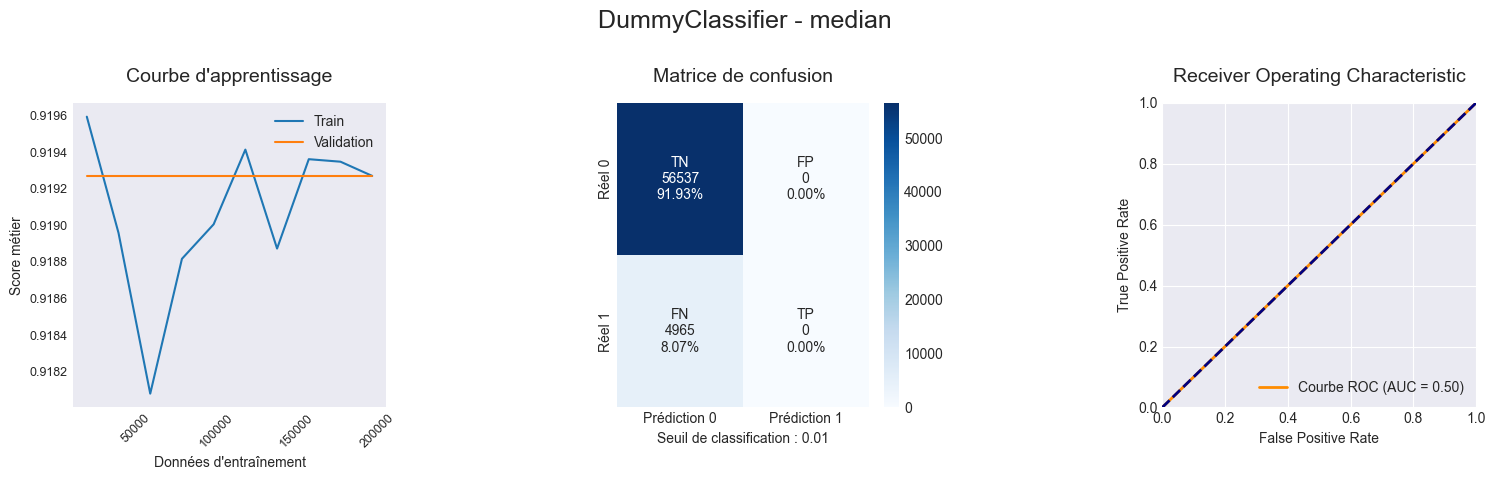

Model: DummyClassifier_median
Best Params: {'model__strategy': 'most_frequent'}
Business Score: 0.9193
Best Threshold: 0.01
AUC Train: 0.5000
AUC Validation: 0.5000
Accuracy Train: 0.9193
Accuracy Validation: 0.9193

Évaluation DummyClassifier (version=median, n_samples=246005) : effectué en 1 min 29 secs.


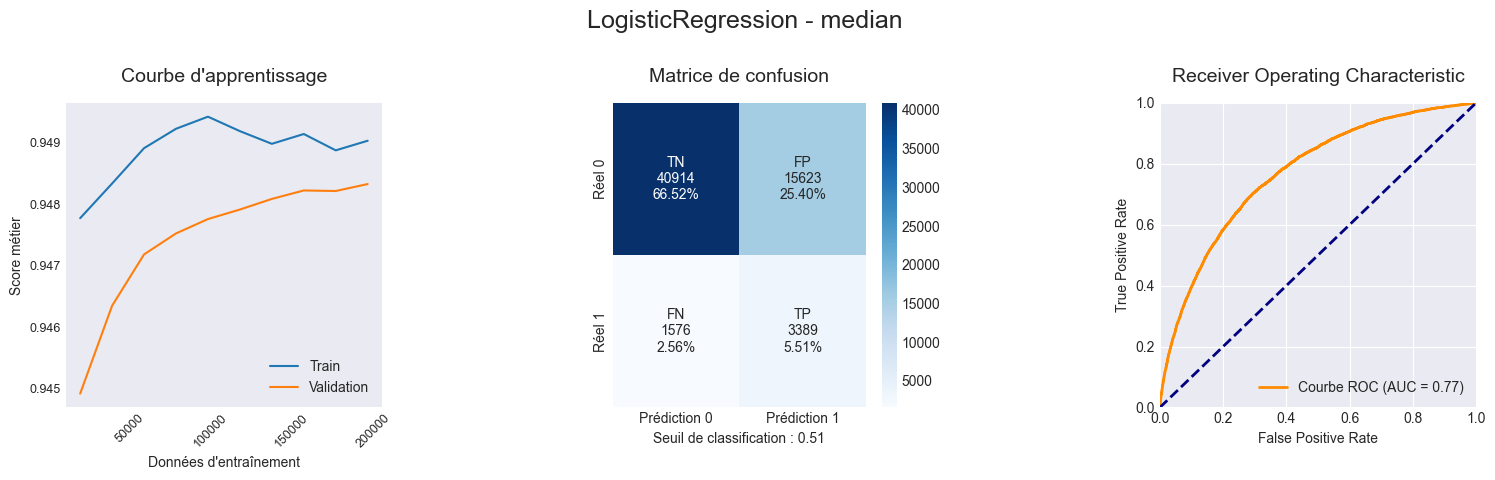

Model: LogisticRegression_median
Best Params: {'model__C': 5e-05, 'model__class_weight': 'balanced', 'model__max_iter': 10000, 'model__solver': 'lbfgs'}
Business Score: 0.9490
Best Threshold: 0.51
AUC Train: 0.7725
AUC Validation: 0.7699
Accuracy Train: 0.7058
Accuracy Validation: 0.7072

Évaluation LogisticRegression (version=median, n_samples=246005) : effectué en 3 min 30 secs.


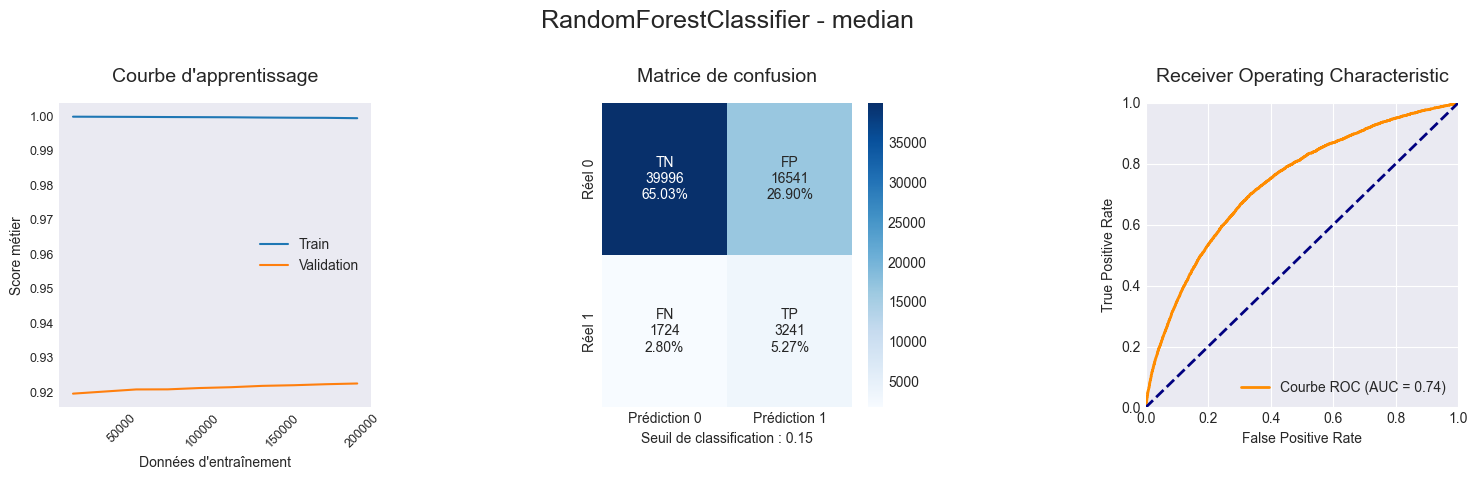

Model: RandomForestClassifier_median
Best Params: {'model__class_weight': 'balanced', 'model__max_depth': 25, 'model__n_estimators': 90, 'model__n_jobs': -1}
Business Score: 0.9451
Best Threshold: 0.15
AUC Train: 0.9997
AUC Validation: 0.7370
Accuracy Train: 0.9965
Accuracy Validation: 0.9157

Évaluation RandomForestClassifier (version=median, n_samples=246005) : effectué en 20 min 28 secs.


C:\Users\chrab\anaconda3\envs\opc07_1\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


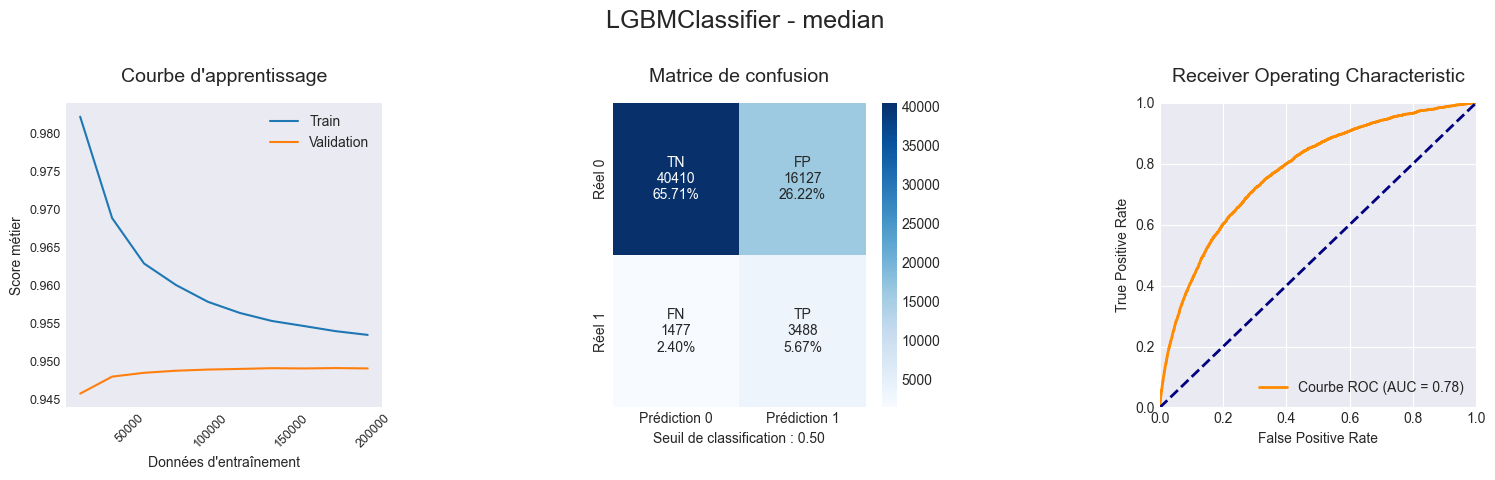

Model: LGBMClassifier_median
Best Params: {'model__force_col_wise': True, 'model__is_unbalance': True, 'model__learning_rate': 0.01, 'model__max_depth': 15, 'model__min_child_samples': 50, 'model__n_estimators': 400, 'model__n_jobs': -1, 'model__num_leaves': 31, 'model__objective': 'binary'}
Business Score: 0.9498
Best Threshold: 0.50
AUC Train: 0.8011
AUC Validation: 0.7772
Accuracy Train: 0.7180
Accuracy Validation: 0.7138

Évaluation LGBMClassifier (version=median, n_samples=246005) : effectué en 41 min 9 secs.


In [21]:
# Évaluation des modèles - median
for model_name in ('DummyClassifier', 'LogisticRegression', 'RandomForestClassifier', 'LGBMClassifier'):
    
    # show = affichage ou non des graphiques
    # save = sauvegarde ou non des graphiques sous forme de fichier png
    results[f'{model_name}_{version}'] = evaluate_model(model_name, version, param_grids, skf, X, y, show=True, save=True)

## 4.2. Valeurs manquantes = moyennes

In [22]:
# Nombre d'overvations pour le train (None = toutes les observations)
n_samples = None

# Version de l'ensemble d'entrainement à utiliser :
# 'nan' = avec données manquantes (seul LightGBM l'autorise)
# 'mean' = données manquantes remplacées par les moyennes
# 'median' = données manquantes remplacée par les médianes
version = 'mean'

# Récupération X et y splités en train/test
X, y = prepare_train_set(version, n_samples)

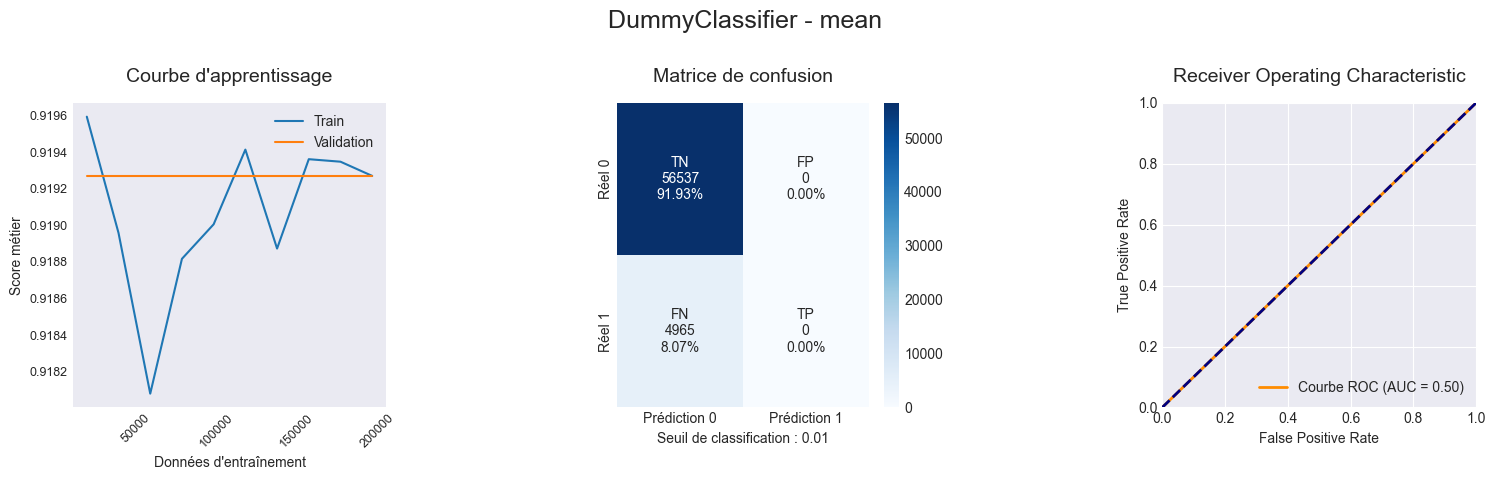

Model: DummyClassifier_mean
Best Params: {'model__strategy': 'most_frequent'}
Business Score: 0.9193
Best Threshold: 0.01
AUC Train: 0.5000
AUC Validation: 0.5000
Accuracy Train: 0.9193
Accuracy Validation: 0.9193

Évaluation DummyClassifier (version=mean, n_samples=246005) : effectué en 1 min 18 secs.


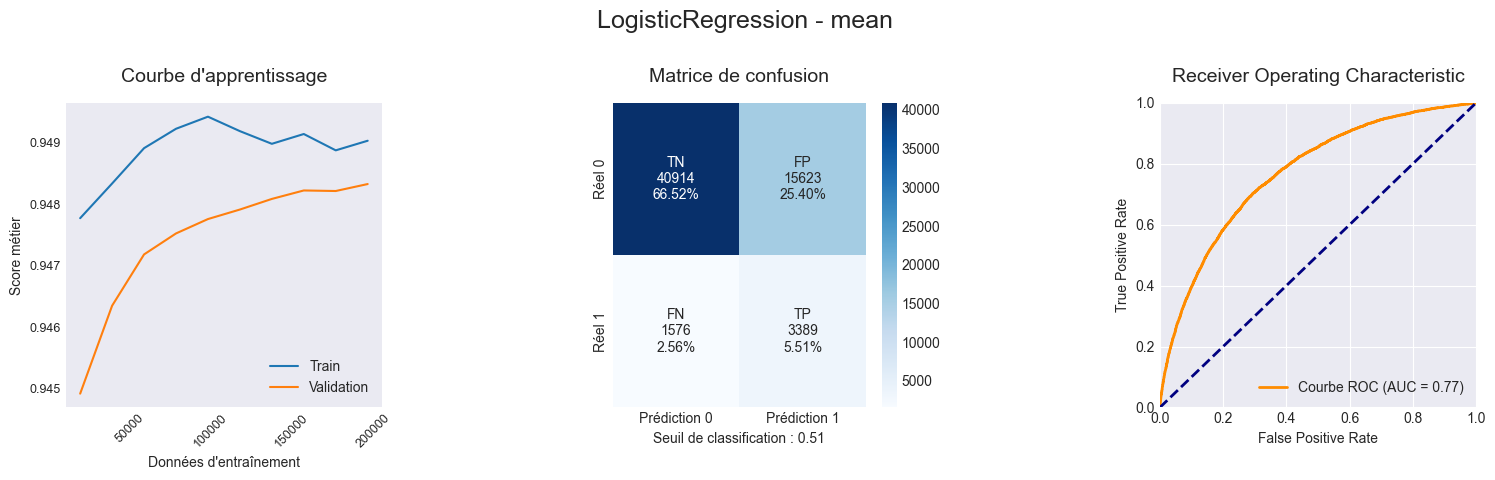

Model: LogisticRegression_mean
Best Params: {'model__C': 5e-05, 'model__class_weight': 'balanced', 'model__max_iter': 10000, 'model__solver': 'lbfgs'}
Business Score: 0.9490
Best Threshold: 0.51
AUC Train: 0.7725
AUC Validation: 0.7699
Accuracy Train: 0.7058
Accuracy Validation: 0.7072

Évaluation LogisticRegression (version=mean, n_samples=246005) : effectué en 3 min 13 secs.


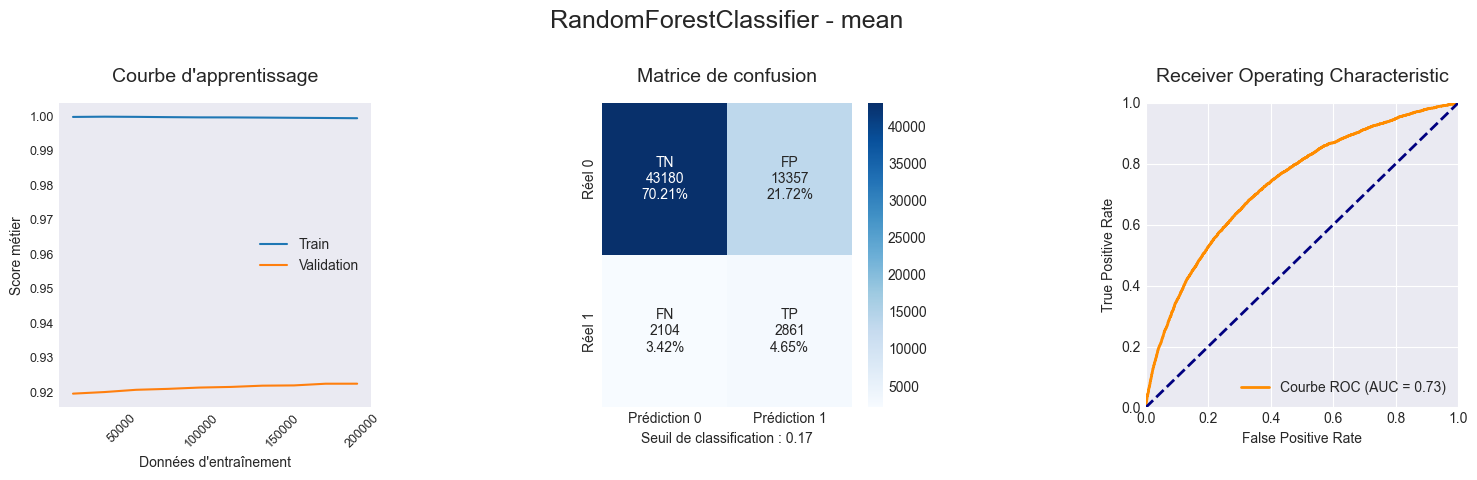

Model: RandomForestClassifier_mean
Best Params: {'model__class_weight': 'balanced', 'model__max_depth': 25, 'model__n_estimators': 75, 'model__n_jobs': -1}
Business Score: 0.9441
Best Threshold: 0.17
AUC Train: 0.9997
AUC Validation: 0.7337
Accuracy Train: 0.9967
Accuracy Validation: 0.9156

Évaluation RandomForestClassifier (version=mean, n_samples=246005) : effectué en 17 min 48 secs.


C:\Users\chrab\anaconda3\envs\opc07_1\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


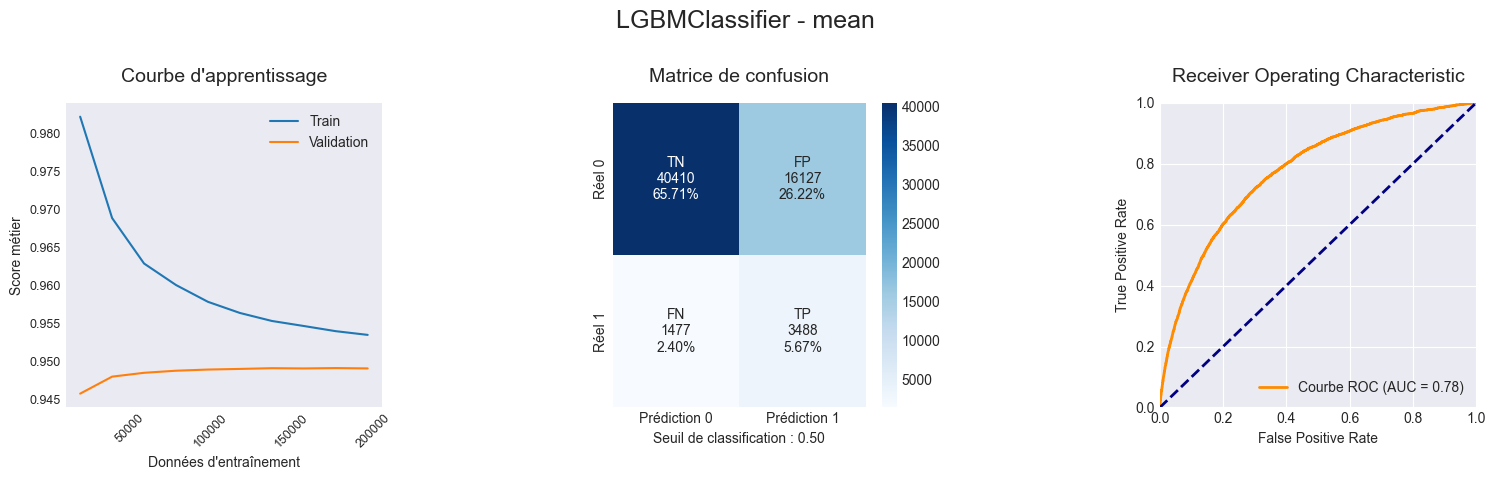

Model: LGBMClassifier_mean
Best Params: {'model__force_col_wise': True, 'model__is_unbalance': True, 'model__learning_rate': 0.01, 'model__max_depth': 15, 'model__min_child_samples': 50, 'model__n_estimators': 400, 'model__n_jobs': -1, 'model__num_leaves': 31, 'model__objective': 'binary'}
Business Score: 0.9498
Best Threshold: 0.50
AUC Train: 0.8011
AUC Validation: 0.7772
Accuracy Train: 0.7180
Accuracy Validation: 0.7138

Évaluation LGBMClassifier (version=mean, n_samples=246005) : effectué en 41 min 41 secs.


In [23]:
# Évaluation d'un modèle
for model_name in ('DummyClassifier', 'LogisticRegression', 'RandomForestClassifier', 'LGBMClassifier'):
    
    # show = affichage ou non des graphiques
    # save = sauvegarde ou non des graphiques sous forme de fichier png
    results[model_name] = evaluate_model(model_name, version, param_grids, skf, X, y, show=True, save=True)

## 4.3. Valeurs manquantes non remplacées 

Seul l'algorithme LightGBM accepte les données avec valeurs manquantes

In [24]:
# Nombre d'observations pour le train (None = toutes les observations)
n_samples = None

# Version de l'ensemble d'entrainement à utiliser :
# 'nan' = avec données manquantes (seul LightGBM l'autorise)
# 'mean' = données manquantes remplacées par les moyennes
# 'median' = données manquantes remplacée par les médianes
version = 'nan'

# Récupération X et y splités en train/test
X, y = prepare_train_set(version, n_samples)

C:\Users\chrab\anaconda3\envs\opc07_1\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


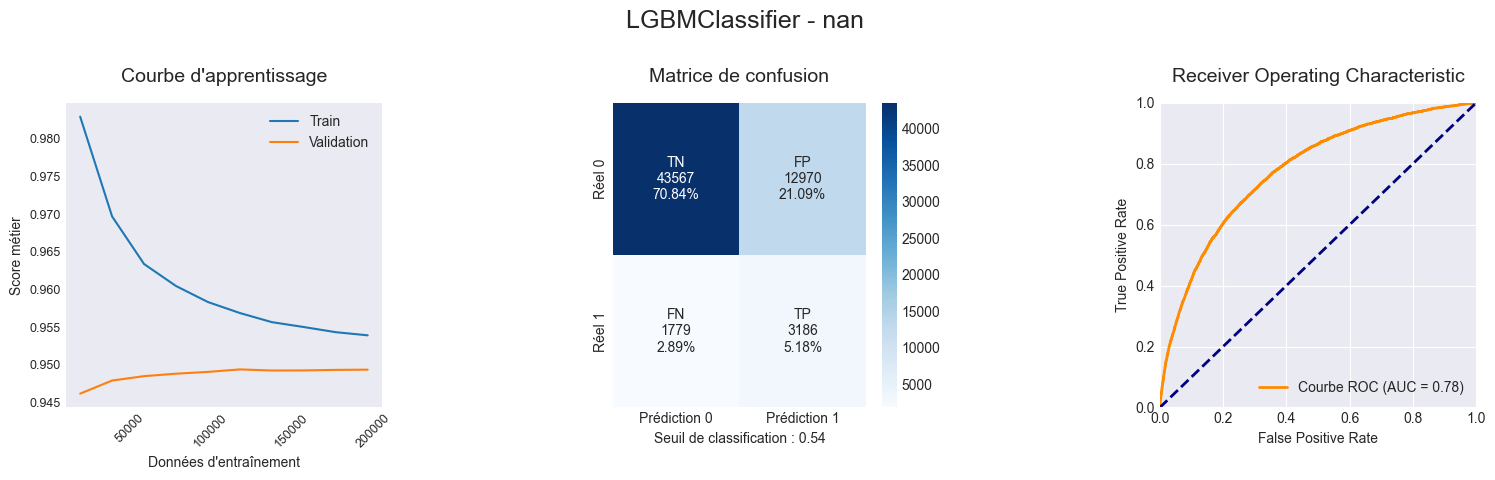

Model: LGBMClassifier_nan
Best Params: {'model__force_col_wise': True, 'model__is_unbalance': True, 'model__learning_rate': 0.01, 'model__max_depth': 15, 'model__min_child_samples': 50, 'model__n_estimators': 400, 'model__n_jobs': -1, 'model__num_leaves': 31, 'model__objective': 'binary'}
Business Score: 0.9500
Best Threshold: 0.54
AUC Train: 0.8029
AUC Validation: 0.7780
Accuracy Train: 0.7206
Accuracy Validation: 0.7137

Évaluation LGBMClassifier (version=nan, n_samples=246005) : effectué en 46 min 13 secs.


In [25]:
# Évaluation des modèles - median
model_name = 'LGBMClassifier'

# show = affichage ou non des graphiques
# save = sauvegarde ou non des graphiques sous forme de fichier png
results[model_name] = evaluate_model(model_name, version, param_grids, skf, X, y, show=True, save=True)

In [26]:
results

{'DummyClassifier_median': {'best_model': Pipeline(steps=[('scaler', StandardScaler()),
                  ('model', DummyClassifier(strategy='most_frequent'))]),
  'best_params': {'model__strategy': 'most_frequent'},
  'best_threshold': 0.01,
  'auc_train': 0.5,
  'accuracy_train': 0.9192699335379362,
  'auc_val': 0.5,
  'accuracy_val': 0.9192709180189262,
  'business_score': 0.9192709180189262},
 'LogisticRegression_median': {'best_model': Pipeline(steps=[('scaler', StandardScaler()),
                  ('model',
                   LogisticRegression(C=5e-05, class_weight='balanced',
                                      max_iter=10000))]),
  'best_params': {'model__C': 5e-05,
   'model__class_weight': 'balanced',
   'model__max_iter': 10000,
   'model__solver': 'lbfgs'},
  'best_threshold': 0.51,
  'auc_train': 0.7724999048703636,
  'accuracy_train': 0.7057702079226033,
  'auc_val': 0.7699484911635637,
  'accuracy_val': 0.7072127735683392,
  'business_score': 0.9489723911417515},
 'Ra

# 5. Tests avec rééquilibrage des classes

La feature cible présente une distribution déséquilibrée, et dans les premiers tests les paramètres `class_weight` des modèles LogicticRegression et RandomForestClassifier, et `is_unbalance` du modèle LGBMClassifier ont été utilisé pour le gérer.  

__SMOTE__ (**S**ynthetic **M**inority **O**versampling **T**echnique) est une technique utilisée pour traiter le déséquilibre des classes, en générant des exemples synthétiques pour la classe mnoritaire, sans duplication des observations existantes.  
La combinaison SMOTE / under-sampling est celle donnant les meilleurs résultats ([SMOTE: Synthetic Minority Over-sampling Technique](https://arxiv.org/abs/1106.1813))

In [61]:
# Utilisation du jeu de données avec valeurs manquantes remplacées par les médianes
X, y = prepare_train_set('median', None)
X_train, X_val = X
y_train, y_val = y

In [62]:
# Répartition modalités feature `TARGET`
y_train_counter = Counter(y_train)
y_val_counter = Counter(y_val)

print("TRAIN SET :")
print(f"Répartition : 0: {y_train_counter[0]} - 1: {y_train_counter[1]}")
print(f"Ratio : 1:{(y_train_counter[0] / y_train_counter[1]):.0f}")

print("\nVALIDATION SET :")
print(f"Répartition : 0: {y_val_counter[0]} - 1: {y_val_counter[1]}")
print(f"Ratio : 1:{(y_val_counter[0] / y_val_counter[1]):.0f}")

TRAIN SET :
Répartition : 0: 226145 - 1: 19860
Ratio : 1:11

VALIDATION SET :
Répartition : 0: 56537 - 1: 4965
Ratio : 1:11


In [63]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

In [65]:
# SMOTE : augmentation du nombre d'observations de classe '1' jusqu'à représenter 50% des observations de classe '0'
over_sampling = SMOTE(sampling_strategy=0.5)

# RandomUnderSampler : diminution du nombre d'observation de classe '0' jusqu'à ce qu'il soit égal au nombre d'observations de classe '1'
under_sampling = RandomUnderSampler(sampling_strategy=1)

# Définition d'un pipeline
pipeline = Pipeline(steps=[('over', over_sampling),
                           ('under', under_sampling)])

# Transformation du jeu de données d'entraînement
x_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)

In [66]:
# Répartition feature `TARGET` après resampling
y_resampled_counter = Counter(y_resampled)

print("TRAIN SET :")
print(f"Répartition : 0: {y_resampled_counter[0]} - 1: {y_resampled_counter[1]}")
print(f"Ratio : 1:{(y_resampled_counter[0] / y_resampled_counter[1]):.0f}")

TRAIN SET :
Répartition : 0: 113072 - 1: 113072
Ratio : 1:1


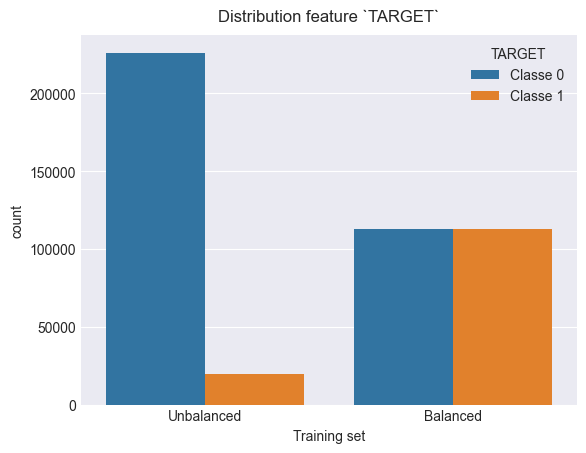

In [68]:
# Préparation DataFrame pour graphique
class_distr_df = pd.DataFrame({'Training set': ['Unbalanced', 'Unbalanced', 'Balanced', 'Balanced'],
                               'TARGET': ['Classe 0', 'Classe 1', 'Classe 0', 'Classe 1'],
                               'count': [y_train_counter[0], y_train_counter[1], Counter(y_resampled)[0], Counter(y_resampled)[1]]})

# Affichage barplot
sns.barplot(class_distr_df, x='Training set', y='count', hue='TARGET')
plt.title("Distribution feature `TARGET`", pad=10)
plt.show()

In [ ]:
# Évaluation des modèles - median
for model_name in ('DummyClassifier', 'LogisticRegression', 'RandomForestClassifier', 'LGBMClassifier'):
    
    # show = affichage ou non des graphiques
    # save = sauvegarde ou non des graphiques sous forme de fichier png
    results[f'{model_name}_{version}'] = evaluate_model(model_name, version, param_grids, skf, X, y, show=True, save=True)